In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import csv

In [31]:
db = pymysql.connect(host = "cdb-r2g8flnu.bj.tencentcdb.com", port = 10209, user
= "dase2020", password = "dase2020", database = "dase_intro_2020")
cursor = db.cursor()

In [32]:
sql = "select * from INFORMATION_SCHEMA.COLUMNS where TABLE_NAME='SH_Grade'"
cursor.execute(sql)
results = cursor.fetchall()
col_names = []
for line in results:
    col_names.append(line[3])
col_names.insert(2, 'Class')

In [33]:
sql = "SELECT * FROM SH_Grade"
cursor.execute(sql)
results = cursor.fetchall()
resultsWithClass = []
for line in results:
    lineList = list(line)
    lineList.insert(2, line[1][0])
    resultsWithClass.append(lineList)

with open("SH_Grade.csv", "w") as fp:
    writer = csv.writer(fp)
    writer.writerow(col_names)
    writer.writerows(resultsWithClass)

In [34]:
stuData = pd.read_csv("SH_Grade.csv")
sizeB = stuData.index.size
stuData = stuData.drop_duplicates(subset=['StuId',])
sizeA = stuData.index.size
print(f"处理前行数：{sizeB}, 处理后行数：{sizeA}")

处理前行数：252, 处理后行数：243


In [35]:
stuData = stuData.dropna(thresh = 47)
sizeB = stuData.index.size
print(f"处理前行数：{sizeA}, 处理后行数：{sizeB}")

处理前行数：243, 处理后行数：189


In [36]:
stuData['Sex'] = stuData["Sex"].fillna(method="ffill")
for i in range(4, 59):
    stuData[col_names[i]] = stuData[col_names[i]].fillna(stuData[col_names[i]].median())

In [37]:
for i in range(4, 59):
    if col_names[i][-3::1] == '822' and col_names[i][0] != "P":
        stuData[col_names[i]] = stuData[col_names[i]].mul(100/120)
    elif stuData[col_names[i]].max() > 100:
        stuData[col_names[i]] = stuData[col_names[i]].mul(100/150)
    elif stuData[col_names[i]].max() <= 60:
        stuData[col_names[i]] = stuData[col_names[i]].mul(100/60)
    elif stuData[col_names[i]].max() <= 90:
        stuData[col_names[i]] = stuData[col_names[i]].mul(100/90)

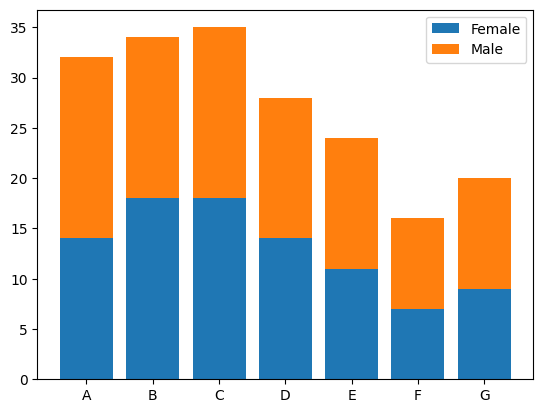

In [38]:
sexNum = stuData.groupby(["Class", "Sex"])["id"].count()
plt.bar(["A", "B", "C", "D", "E", "F", "G"], sexNum[::2], label = "Female")
plt.bar(["A", "B", "C", "D", "E", "F", "G"], sexNum[1::2], bottom = sexNum[::2], label = "Male")
plt.legend()
plt.show()

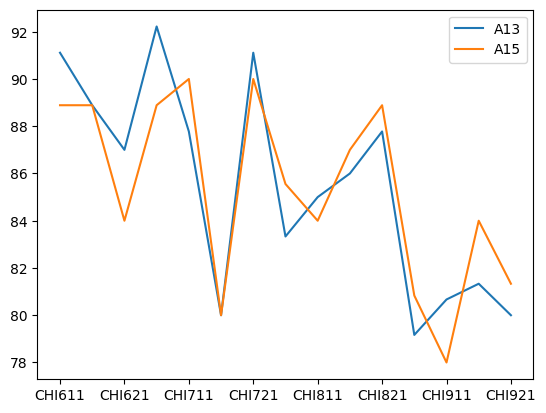

In [39]:
chiScores = stuData.filter(regex="^CHI[0-9]*").loc[(stuData["StuId"] == "A13") | (stuData["StuId"] == "A15")]
plt.plot(chiScores.columns, chiScores.iloc[0], label = "A13")
plt.plot(chiScores.columns, chiScores.iloc[1], label = "A15")
plt.xticks(chiScores.columns[::2])
plt.legend()
plt.show()

In [40]:
stuFailedInCHI721OrENG721 = stuData.query("CHI721 < 60 or ENG721 < 60").filter(regex = "^(Class|StuId|((CHI|ENG)721))").set_index("StuId")
print(stuFailedInCHI721OrENG721)

      Class     CHI721  ENG721
StuId                         
B17       B  46.666667    30.0
D02       D  83.333333    51.0
D13       D  81.111111    54.0
D29       D  84.444444    54.0
E14       E  71.111111    47.0
E22       E  72.222222    46.0
E23       E  75.555556    54.0
E26       E  58.888889    26.0
E28       E  53.333333    36.0
E29       E  77.777778    53.0
E30       E  53.333333    34.0
E31       E  84.444444    56.0
F09       F  74.444444    36.0
F10       F  67.777778    37.0
F11       F  55.555556    34.0
F18       F  64.444444    53.0
F27       F  80.000000    53.0
G08       G  70.000000    53.0
G13       G  74.444444    41.0
G14       G  53.333333    52.0
G25       G  85.555556    44.0
G26       G  38.888889    76.0


In [41]:
mean = stuData.groupby("Class").mean(numeric_only = True).filter(regex="622$").loc[["A", "C"]]
print(mean)
var = stuData.groupby("Class").var(numeric_only = True).filter(regex="622$").loc[["A", "C"]]
print(var)
#A班级的语文和数学成绩较好，C班级的英语成绩较好

          CHI622  MATH622     ENG622
Class                               
A      90.451389    90.75  89.968750
C      85.523810    89.20  91.257143
          CHI622    MATH622     ENG622
Class                                 
A      35.432845  19.935484  32.160282
C      32.424525  71.694118  37.608403


In [42]:
stuData.to_csv("task8.csv")